In [15]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from scipy import stats
import matplotlib.gridspec as gridspec
from collections import Counter
import requests
import math

In [16]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [17]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [18]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [19]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [20]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [21]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [22]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [23]:
add_syn_mut_attribute(tree)

In [24]:
for node in tree.find_clades(terminal=False):

    node.s1_nonsyn_at_node = 0
    node.s1_syn_at_node = 0
    node.rdrp_nonsyn_at_node = 0

    if hasattr(node, "node_attrs") and 'S1' in node.node_attrs['syn_muts']:
        node.s1_syn_at_node = len(node.node_attrs['syn_muts']['S1'])


    if hasattr(node, 'branch_attrs'):

        s1_nonsyn_at_this_node = []
        if "S" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["S"]:
                if int(mut[1:-1]) in range(14,686):
                    s1_nonsyn_at_this_node.append(mut)

        s1_consolidated = consolidate_deletions(s1_nonsyn_at_this_node)
        node.s1_nonsyn_at_node = len(s1_consolidated)



        rdrp_nonsyn_at_this_node = []
        if "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_nonsyn_at_this_node.append(mut)


        if "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_nonsyn_at_this_node.append(mut)

        rdrp_consolidated = consolidate_deletions(rdrp_nonsyn_at_this_node)
        node.rdrp_nonsyn_at_node = len(rdrp_consolidated)


In [25]:
def get_branches_with_muts(gene, mutation):
    
    mut_history = {}
    
    for node in tree.find_clades(terminal=False):

        if len(node.get_terminals()) >=10:
            
            # finds branchs with the mutation
            if hasattr(node, "branch_attrs") and "mutations" in node.branch_attrs:
                if gene in node.branch_attrs["mutations"]:
                    for m in node.branch_attrs["mutations"][gene]:
                        if mutation in m:
                            s1_this_node = node.s1_nonsyn_at_node
                            rdrp_this_node = node.rdrp_nonsyn_at_node

                            mut_date = node.node_attrs["num_date"]["value"]
                            start_date = get_parent(tree, node)[0].node_attrs["num_date"]["value"]
                            time_before_mut = mut_date - start_date


                            direct_parent = get_parent(tree, node)[-2]
                            s1_before = direct_parent.node_attrs['S1_mutations']['value']
                            
                            rdrp_before = 0
                            all_parents = get_parent(tree, node)[:-1]
                            for p in all_parents:
                                rdrp_before+=p.rdrp_nonsyn_at_node
                                
                            s1_syn_before = 0
                            all_parents = get_parent(tree, node)[:-1]
                            for p in all_parents:
                                s1_syn_before+=p.s1_syn_at_node
                                
                            

                            mut_history[node.name] = {'branch_with_mut':node.name, 
                                                         's1_muts_at_branch': s1_this_node, 
                                                         'rdrp_muts_at_branch': rdrp_this_node, 
                                                         's1_muts_before': s1_before, 
                                                         'rdrp_muts_before': rdrp_before,
                                                          's1_syn_before': s1_syn_before, 
                                                         's1_total_at_branch': node.node_attrs['S1_mutations']['value'],
                                                         'rdrp_total_at_branch': rdrp_before+rdrp_this_node, 
                                                         'mut_date': mut_date, 
                                                         'time_before_mut': time_before_mut, 
                                                         's1_muts_per_year_before': s1_before/time_before_mut, 
                                                         'rdrp_muts_per_year_before': rdrp_before/time_before_mut}
    return mut_history   

In [26]:
def num_muts_in_children(gene, mutation):
    
    mut_history = get_branches_with_muts(gene, mutation)
    

    branchs_with_mut = [x for x in mut_history.keys()]
    
    
    
    for branch_w_mut in branchs_with_mut:
        s1_muts_in_children = []
        s1_mut_totals_in_children = []
        s1_muts_per_year_in_children = []
        
        rdrp_mut_totals_in_children = []
        rdrp_muts_per_year_in_children = []
        
        s1_syn_totals_in_children = []
        for node in tree.find_clades(terminal=False):
            # check every branch to see if it is a child of a branch with the specified mutation
            parents = get_parent(tree, node)[:-1]
            parent_names = [p.name for p in parents]
            if branch_w_mut in parent_names:
                
                if "S1_mutations" in node.node_attrs:
                
                    date_this_node = node.node_attrs["num_date"]["value"]
                    mut_date = mut_history[branch_w_mut]['mut_date']
                    time_after_mut = date_this_node - mut_date

                    s1_this_node = node.s1_nonsyn_at_node
                    s1_total = node.node_attrs['S1_mutations']['value']

                    s1_total_at_mut = mut_history[branch_w_mut]['s1_total_at_branch']
                    
                    # if mutation itself is in S1, don't count it as "descending from" itself
                    # needs to be removed from s1_total and s1_total_at_mut
                    if gene=='S' and int(mutation[:-1])in range(14,686):
                        s1_total = s1_total - 1
                        s1_total_at_mut = s1_total_at_mut -1

                    s1_muts_per_year_after = (s1_total-s1_total_at_mut)/time_after_mut

                    s1_muts_in_children.append(s1_this_node)
                    s1_mut_totals_in_children.append(s1_total)
                    s1_muts_per_year_in_children.append(s1_muts_per_year_after)
                    
                    rdrp_this_node = node.rdrp_nonsyn_at_node
                    rdrp_total=0
                    all_parents = get_parent(tree, node)[:-1]
                    for p in all_parents:
                        rdrp_total+=p.rdrp_nonsyn_at_node 
                        
                    rdrp_total_at_mut = mut_history[branch_w_mut]['rdrp_total_at_branch']
                    rdrp_muts_per_year_after = (rdrp_total-rdrp_total_at_mut)/time_after_mut
                    
                    rdrp_mut_totals_in_children.append(rdrp_total)
                    rdrp_muts_per_year_in_children.append(rdrp_muts_per_year_after)
                    
                    syn_this_node = node.s1_syn_at_node
                    syn_total=0
                    all_parents = get_parent(tree, node)[:-1]
                    for p in all_parents:
                        syn_total+=p.s1_syn_at_node 
                    
                    s1_syn_totals_in_children.append(syn_total)


        mut_history[branch_w_mut]['s1_muts_after'] = s1_mut_totals_in_children
        mut_history[branch_w_mut]['s1_muts_diff'] = [x -  mut_history[branch_w_mut]['s1_muts_before'] for x in s1_mut_totals_in_children]
        mut_history[branch_w_mut]['rdrp_muts_after'] = rdrp_mut_totals_in_children
        mut_history[branch_w_mut]['rdrp_muts_diff'] = [x -  mut_history[branch_w_mut]['rdrp_muts_before'] for x in rdrp_mut_totals_in_children]
        mut_history[branch_w_mut]['s1_syn_after'] = s1_syn_totals_in_children
        mut_history[branch_w_mut]['s1_syn_diff'] = [x -  mut_history[branch_w_mut]['s1_syn_before'] for x in s1_syn_totals_in_children]

        
        mut_history[branch_w_mut]['s1_muts_per_year_after'] = s1_muts_per_year_in_children
        mut_history[branch_w_mut]['rdrp_muts_per_year_after'] = rdrp_muts_per_year_in_children
        mut_history[branch_w_mut]['s1_muts_per_year_after_avg'] = sum(s1_muts_per_year_in_children)/len(s1_muts_per_year_in_children)
        mut_history[branch_w_mut]['rdrp_muts_per_year_after_avg'] = sum(rdrp_muts_per_year_in_children)/len(rdrp_muts_per_year_in_children)        
        
    
    return mut_history
    
    

In [27]:
def fig4a(list_of_muts, filename=None):
    to_plot_s1 = []
    to_plot_rdrp = []
    to_plot_diffs = []

    for m in list_of_muts:
        gene = m.split(':')[0]
        mutation = m.split(':')[1]

        mut_history = num_muts_in_children(gene, mutation)

        s1_totals_before = []
        s1_totals_after = []
        s1_diff = []
        
        s1_syn_diff = []

        rdrp_totals_before = []
        rdrp_totals_after = []
        rdrp_diff = []

        for x in mut_history.keys():
            s1_totals_before.append(mut_history[x]['s1_muts_before'])
            s1_totals_after+=mut_history[x]['s1_muts_after']
            s1_diff+=mut_history[x]['s1_muts_diff']
            s1_syn_diff+=mut_history[x]['s1_syn_diff']
            rdrp_totals_before.append(mut_history[x]['rdrp_muts_before'])
            rdrp_totals_after+=mut_history[x]['rdrp_muts_after']
            rdrp_diff+=mut_history[x]['rdrp_muts_diff']
        
        if m=='ORF1a:3675-':
            m_label = 'ORF1a:3675-3677del'
        else:
            m_label =m
        
        for b_s in s1_totals_before:
            to_plot_s1.append({'timepoint': 'before', 's1_muts': b_s, 'mutation': m_label})
        for a_s in s1_totals_after:
            to_plot_s1.append({'timepoint': 'after', 's1_muts': a_s, 'mutation': m_label})
        for d_s in s1_diff:
            to_plot_s1.append({'timepoint': 'difference', 's1_muts': d_s, 'mutation': m_label})
            to_plot_diffs.append({'gene': 's1', 'difference': d_s, 'mutation':m_label})
            
        for d_s_s in s1_syn_diff:
            to_plot_diffs.append({'gene': 's1_syn', 'difference': d_s_s, 'mutation':m_label})

        for b_r in rdrp_totals_before:
            to_plot_rdrp.append({'timepoint': 'before', 'rdrp_muts': b_r, 'mutation': m_label})
        for a_r in rdrp_totals_after:
            to_plot_rdrp.append({'timepoint': 'after', 'rdrp_muts': a_r, 'mutation': m_label})
        for d_r in rdrp_diff:
            to_plot_rdrp.append({'timepoint': 'difference', 'rdrp_muts': d_r, 'mutation': m_label})
            to_plot_diffs.append({'gene': 'rdrp', 'difference': d_r, 'mutation':m_label})

    to_plot_s1_df = pd.DataFrame(to_plot_s1)
    to_plot_rdrp_df = pd.DataFrame(to_plot_rdrp)
    to_plot_diffs_df = pd.DataFrame(to_plot_diffs)
    
    
    fig, ax = plt.subplots(figsize=(8,8))

    cmap = {'s1':"#4770eb", 'rdrp': "#ff8c3a", 's1_syn':"#a7c9f1"}

    mutation_ranks = to_plot_diffs_df[to_plot_diffs_df['gene']=='s1'
                                     ].groupby('mutation')['difference'].mean().rank(ascending=False).to_dict()
    ranked_mutations = [k for k, v in sorted(mutation_ranks.items(), key=lambda item: item[1])]

    ax = sns.pointplot(x='mutation', y='difference', data=to_plot_diffs_df, 
                       hue='gene',palette=cmap, order= ranked_mutations, hue_order=['s1', 's1_syn', 'rdrp'],
                       join=False, dodge=True, ax=ax, scale=1.5, errwidth=1.5)

    ax.set_ylabel('Mean increase in mutations after specified event', fontsize = 14)
    ax.set_xlabel('Event', fontsize = 14)


    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, ['S1', 'S1 syn', 'RdRp'], loc='upper center', bbox_to_anchor=(0.85, 0.95), 
                     title = 'Mutations')
    

    plt.xticks(rotation=40, va='top', ha='right')

    sns.despine(left=False, bottom=False)
    
    plt.figtext(0.05, 0.88, 'A', fontsize=24, fontweight='bold')
    
    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')


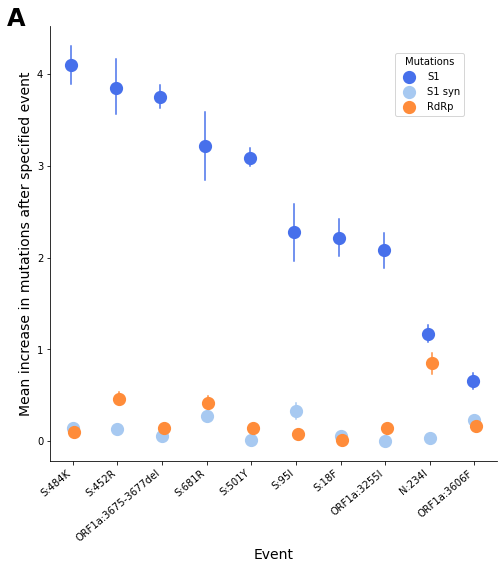

In [28]:
fig4a(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F',
       'S:484K', 'S:452R', 'S:681R', 'N:234I'], filename='plots/fig4a_20210515.png')

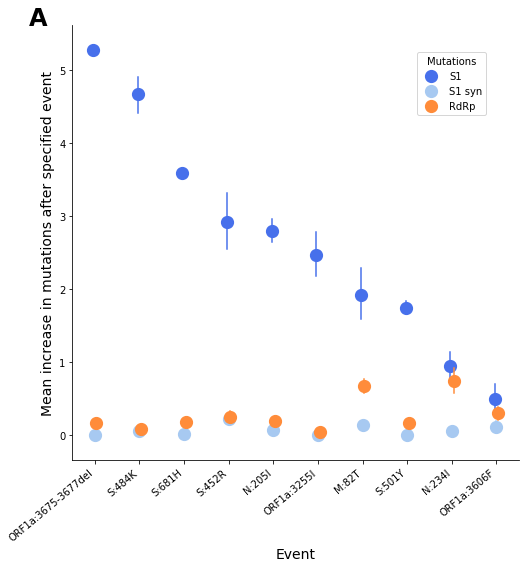

In [283]:
fig4a(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 
       'S:484K', 'S:452R', 'S:681H', 'N:234I', 'N:205I', 'M:82T'], filename='plots/fig4a_20210515.png')

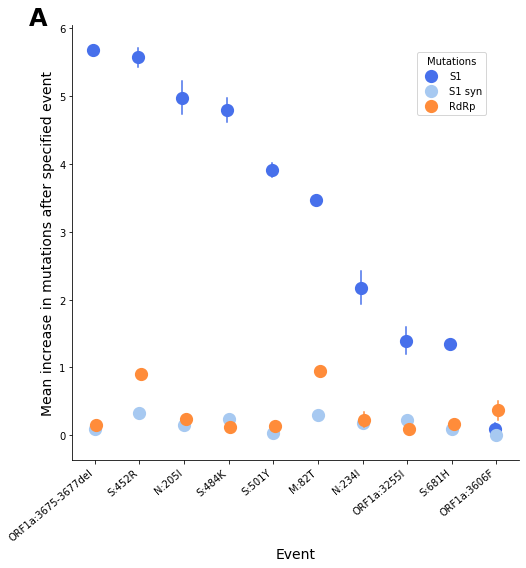

In [288]:
# current
fig4a(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 
       'S:484K', 'S:452R', 'S:681H', 'N:234I', 'N:205I', 'M:82T'])